# LightGCN 
References:
* https://github.com/microsoft/recommenders
* https://www.youtube.com/playlist?list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn
* https://medium.com/stanford-cs224w/recommender-systems-with-gnns-in-pyg-d8301178e377
* https://medium.com/stanford-cs224w/lightgcn-for-movie-recommendation-eb6d112f1e8
* https://medium.com/stanford-cs224w/alexa-queue-that-banger-87c79b0631cf

In [323]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import random
import time
from tqdm.notebook import tqdm

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree
from sklearn.metrics import mean_squared_error

## Preprocessing Aid
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [324]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [325]:
data = pd.read_csv("source/supporting/goodreads_interactions.csv")

# TESTING MODE
data = data.iloc[0:500000]

In [ ]:
## Capping at 100,000 due to limited computer resources
books = pd.read_json("source/supporting/goodreads_books.json", lines=True, nrows=100000, orient="records")
books = books[['book_id','title','similar_books','description','ratings_count']]
books = data.merge(books, how='left', left_on="book_id", right_on="book_id")

In [327]:
## Focus on read and reviewed only i.e., remove is_reviewed == 0 and rating == 0
data = data[(data['is_reviewed']==1)&(data['rating']!=0)]

## Focus on users that have more than 10 book ratings
ratings_per_user = data[(data['is_reviewed']==1)&(data['rating']!=0)].groupby('user_id').size().reset_index(name='number_of_ratings_per_user')
data = data[data.user_id.isin(set(ratings_per_user[ratings_per_user['number_of_ratings_per_user']>=10]['user_id']))]

## Focus on ratings >= 3  
## NOTE: in the future could use no rating - rating 2 as negative data? 
data = data[data.rating>=3]

## Remove is_reviewed and is_read
data = data[['user_id','book_id','rating']]

In [326]:
# Basic statistics about the dataset
print(f"Total number of entries = {len(data)}")
print(f"Total number of unique users = {len(set(data['user_id']))}")
print(f"Total number of unique books = {len(set(data['book_id']))}")

Total number of entries = 500000
Total number of unique users = 1034
Total number of unique books = 181946


In [328]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(data.values, test_size=0.2, random_state=17)
train_df = pd.DataFrame(train, columns=data.columns)
test_df = pd.DataFrame(test, columns=data.columns)
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  25215
Test Size :  6304


In [329]:
## Relabel IDs train set for both user and book ids
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['book_id_idx'] = le_item.fit_transform(train_df['book_id'].values)

In [330]:
## Test items that are only present in the train set (i.e., user and book id that are in train set)
test_df = test_df[(test_df['user_id'].isin(train_df['user_id'].unique())) & (test_df['book_id'].isin(train_df['book_id'].unique()))]

## Relabel IDs for test set for both user and book ids
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['book_id_idx'] = le_item.transform(test_df['book_id'].values)

In [331]:
## Preparing for Micorosft's Input -- requires timestamp even though timestamp isn't used
train_df = train_df[['user_id_idx','book_id_idx','rating']]
train_df.rename(columns={"user_id_idx":"userID", "book_id_idx":"itemID"}, inplace =True)
train_df['timestamp'] = 0

test_df = test_df[['user_id_idx','book_id_idx','rating']]
test_df.rename(columns={"user_id_idx":"userID", "book_id_idx":"itemID"}, inplace =True)
test_df['timestamp'] = 0

## Used for downstream processes
combineDF = pd.concat([train_df,test_df])

In [332]:
## Print number of unique users and books after filter
n_users = train_df['userID'].nunique()
n_items = train_df['itemID'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Books : ", n_items)

Number of Unique Users :  398
Number of unique Books :  20177


In [333]:
## PyG represents graphs as sparse lists of node pairs
u_t = torch.LongTensor(train_df.userID)
i_t = torch.LongTensor(train_df.itemID) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)

# MANUAL LIGHTGCN

#### SUPPORT

In [334]:
def miniBatchSampler(interected_items_df, batch_size, n_usr, n_itm):
    """
    return: subset of data of size batch_size with one positive and negative sample for a given user
    """
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id
    
    ## Get list of book ids each user has interacted with
#     interected_items_df = data.groupby('user_id_idx')['book_id_idx'].apply(list).reset_index()
    
    ## Select a batch_size random subset of users via train/test dataset
    indices = list(range(n_usr))
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users_df = pd.DataFrame(users,columns = ['users']).sort_values("users").reset_index(drop=True)
    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'userID', right_on = 'users')
    
    ## Select a random book from each of the batch_size randomly selected users for each user
    pos_items = interected_items_df['itemID'].apply(lambda x : random.choice(x)).values
    
    ## Select a random book from each of the batch_size randomly selected users for each user that user
    ## doesn't interact with
    neg_items = interected_items_df['itemID'].apply(lambda x: sample_neg(x)).values
    
    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
    # compute loss from initial embeddings, used for regulization
    reg_loss = (1 / 2) * (user_emb0.norm().pow(2)+pos_emb0.norm().pow(2)+neg_emb0.norm().pow(2))/float(len(users))

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)
    
    ## This is taken directly from the authors of LightGCN - Line69 https://github.com/gusye1234/LightGCN-PyTorch/blob/master/code/model.py
    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))
    return bpr_loss, reg_loss

#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, interaction_data, test_data, K):
    
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))
    
    # create dense tensor of all user-item interactions
        ## 1 if there is an interaction, 0 otherwise
        ## NOTE: i has the correct indices and 
    
    i = torch.stack((
        torch.LongTensor(interaction_data['userID'].values),
        torch.LongTensor(interaction_data['itemID'].values)
        ))
    v = torch.ones((len(interaction_data)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_score = torch.topk(relevance_score, K).values
    
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['userID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['userID','top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item interactions
    test_interacted_items = test_data.groupby('userID')['itemID'].apply(list).reset_index()
    
    # Metrics
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'userID',right_on = 'userID')
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.itemID, metrics_df.top_rlvnt_itm)]
    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['itemID']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
def predictTopK(userEmb, bookEmb, combineDF, userID, K):
    ## Obtain ranking score of items for given user [userID]
    relevance_score = torch.matmul(userEmb[userID], torch.transpose(bookEmb,0, 1))

    ## Return top K scores
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_score = torch.topk(relevance_score, K).values

    ## DF
    returnDF = pd.DataFrame({"score":topk_relevance_score.cpu().numpy(),"itemID":topk_relevance_indices.cpu().numpy()})
    returnDF = returnDF.rename_axis('rank').reset_index()
    all_interacted_items = combineDF[combineDF["userID"]==userID].groupby('userID')['itemID'].apply(list).iloc[0]
    returnDF['True?'] = returnDF.apply(lambda x: True if x.itemID in all_interacted_items else False, axis=1)
    return returnDF 

#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
def predictTopKAll(userEmb, itemEmb, train_df, test_df, K):
    ## Obtain ranking score of items for given user [userID]
    relevance_score = torch.matmul(userEmb, torch.transpose(itemEmb,0, 1))

    ## Return top K scores
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_score = torch.topk(relevance_score, K).values

    ## DF
    returnDF = pd.DataFrame({"userID":np.repeat(train_df['userID'].sort_values().drop_duplicates().values, K),\
                             "itemID":topk_relevance_indices.flatten().numpy(),\
                             "prediction":topk_relevance_score.flatten().numpy()})
    return returnDF 

#### MODEL BUILDING

In [335]:
## Single Layer
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):  
        super().__init__(aggr='add')
    
    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

## Multi-layer
class LightGCN(nn.Module):
    def __init__(self, train_data, num_layers, num_users, num_items, emb_size=16):
        super(LightGCN, self).__init__()
        assert (num_layers >= 1), 'Number of layers is not >=1'
        self.num_layers = num_layers
        self.emb_size = emb_size
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
        self.embedding = nn.Embedding(num_users + num_items, emb_size)
        # Authors of LightGCN report higher results with normal initialization
            ## Fills the input Tensor with values drawn from the normal distribution N(0,0.1)
        nn.init.normal_(self.embedding.weight, std=0.1) 

    ## Gather embeddings from each layer and apply the mean on the output of all hidden layers
    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)
        out = torch.mean(torch.stack(embs, dim=0), dim=0)
        return emb0, out
    

In [336]:
def trainANDtest(model, optimizer, train_df, interected_items_df, edge_index, args):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []
    recall_list = []
    precision_list = []
    
    n_users = train_df['userID'].nunique()
    n_items = train_df['itemID'].nunique()

    for epoch in tqdm(range(args['epochs'])):
        n_batch = int(len(train_df)/args['batch_size'])
        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []
        model.train()
        for batch_idx in range(n_batch):

            optimizer.zero_grad()
            users, pos_items, neg_items = miniBatchSampler(interected_items_df, args['batch_size'], n_users, n_items)        
        
            ## OBTAIN INITIAL AND FINAL EMBEDDING
            emb0, out = model(edge_index)
    
            ## COMPUTE LOSS USING INITIAL AND FINAL EMBEDDINGS FOR BATCH
            bpr_loss, reg_loss = compute_bpr_loss(users, out[users], out[pos_items], out[neg_items], emb0[users],  emb0[pos_items], emb0[neg_items])
            reg_loss = args['decay'] * reg_loss
            final_loss = bpr_loss + reg_loss
            final_loss.backward()
            optimizer.step()
            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())
            
        ## TRAINING ERROR OF EPOCH (MEAN)  
        loss_list_epoch.append(round(np.mean(final_loss_list),4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

        ## TRAINING RECALL AND PRECISION USING HELD OUT RESULTS IN TEST_DF
        model.eval()
        with torch.no_grad():
            _, out = model(edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall,  test_topK_precision = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, args['K'])

        recall_list.append(round(test_topK_recall,4))
        precision_list.append(round(test_topK_precision,4))

    return final_user_Embed, final_item_Embed, (loss_list_epoch, 
            bpr_loss_list_epoch, 
            reg_loss_list_epoch, 
            recall_list, 
            precision_list)


#### TRAIN

In [337]:
## SETUP
args = {
    'n_layers' : 3,
    'emb_size' : 64,
    'epochs' : 50,
    'decay': 1e-5,
    'lr': 0.005,
    'batch_size' : 1024,
    'K':20,
    'seed':17,
    "eval_epoch":5
}

In [338]:
## INITIALIZE AND TRAIN
lightgcn = LightGCN(train_df, args['n_layers'], n_users, n_items, emb_size=args['emb_size'])
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=args['lr'])
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

## FINAL RESULTS
interected_items_df = train_df.groupby('userID')['itemID'].apply(list).reset_index()
final_user_Embed, final_item_Embed, results = trainANDtest(lightgcn, optimizer, train_df, interected_items_df, train_edge_index, args)
loss, bpr, reg, recall, precision = results

Size of Learnable Embedding :  [torch.Size([20575, 64])]


  0%|          | 0/50 [00:00<?, ?it/s]

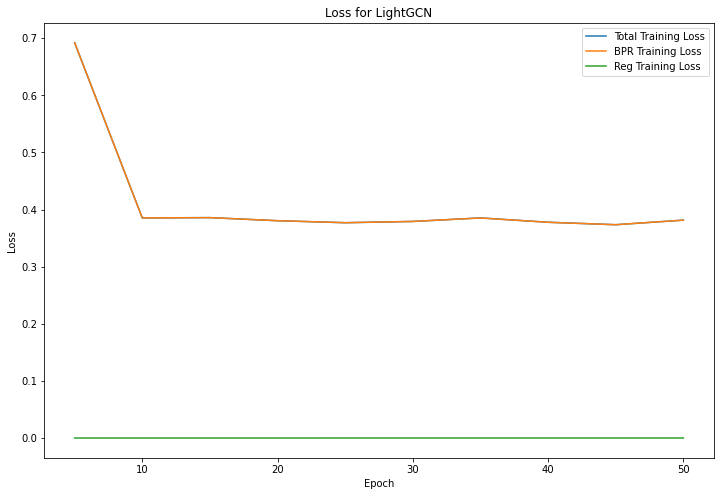

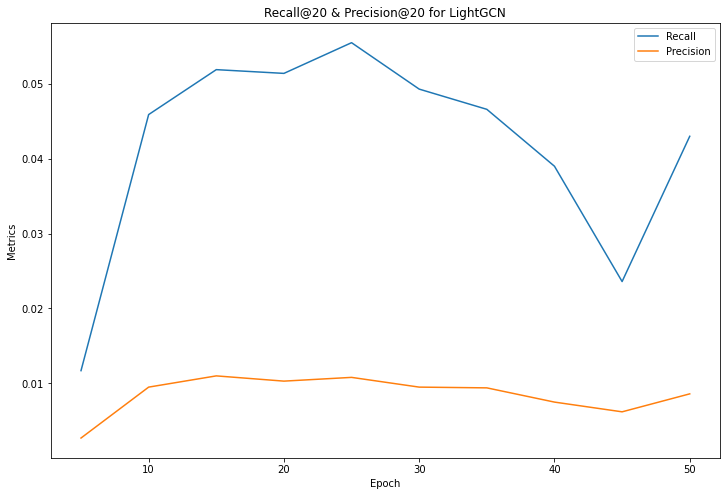

In [339]:
## PLOT RESULTS
epoch_list = list(range(args['eval_epoch'],args['epochs']+1,args['eval_epoch']))

fig = plt.figure(figsize=(12,8))
plt.plot(epoch_list, loss[::args['eval_epoch']], label='Total Training Loss')
plt.plot(epoch_list, bpr[::args['eval_epoch']] , label='BPR Training Loss')
plt.plot(epoch_list, reg[::args['eval_epoch']] , label='Reg Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Loss for LightGCN")
plt.legend()
plt.show()

fig = plt.figure(figsize=(12,8))
plt.plot(epoch_list, recall[::args['eval_epoch']] , label='Recall')
plt.plot(epoch_list, precision[::args['eval_epoch']] , label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title(f"Recall@{args['K']} & Precision@{args['K']} for LightGCN")
plt.legend()
plt.show()

In [340]:
topk_scores = predictTopKAll(final_user_Embed, final_item_Embed, train_df, test_df, K=args['K'])
eval_map = map_at_k(test_df, topk_scores, k=args['K'])
eval_precision = precision_at_k(test_df, topk_scores, k=args['K'])
eval_recall = recall_at_k(test_df, topk_scores, k=args['K'])

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.012715
Precision@K:	0.009365
Recall@K:	0.047757


In [341]:
predictTopKAll(final_user_Embed, final_item_Embed, train_df, test_df, K=args['K'])

,userID,itemID,prediction
0,0,595,8.248468
1,0,173,7.492886
2,0,267,6.914394
3,0,672,6.759351
4,0,565,6.551715
...,...,...,...
7955,397,558,6.746322
7956,397,633,6.702136
7957,397,5890,6.698280
7958,397,679,6.682994


In [342]:
## Error somewhere in the code -- predicting only 52 items
len(set(topk_scores['itemID']))

78

In [345]:
## MERGE BOOKS WITH TITLES AND COMPARE
predictTopK(final_user_Embed, final_item_Embed, combineDF, userID=3, K=20)

,rank,score,itemID,True?
0,0,4.344011,595,True
1,1,3.688305,267,False
2,2,3.600038,173,False
3,3,3.397644,1866,False
4,4,3.396638,672,False
5,5,3.370777,567,False
6,6,3.369359,565,False
7,7,3.349603,3536,False
8,8,3.342956,14288,False
9,9,3.319023,1179,False


# MICROSOFTS LIGHTGCN MODULE

In [346]:
from recommenders.utils.timer import Timer
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.deeprec.deeprec_utils import prepare_hparams

yaml_file = "./lightgcn.yaml"

In [347]:
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
def predictTopK(model, train_df, test_df, userID, K, removeSeen=False):
    ## Obtain ranking score of items for given user [userID]
    releventDF = model.recommend_k_items(test_df, top_k=K, remove_seen=removeSeen)
    releventDF = releventDF[releventDF['userID']==userID]
    
    ## DF
    interaction_train = train_df[train_df["userID"]==userID].groupby('userID')['itemID'].apply(list).iloc[0]
    interaction_test = test_df[test_df["userID"]==userID].groupby('userID')['itemID'].apply(list).iloc[0]
    releventDF['inTrain'] = releventDF.apply(lambda x: True if x.itemID in interaction_train else False, axis=1)
    releventDF['inTest'] = releventDF.apply(lambda x: True if x.itemID in interaction_test else False, axis=1)
    return releventDF 

In [348]:
data_ = ImplicitCF(train=train_df, test=test_df, seed=args['seed'])

hparams = prepare_hparams(yaml_file,
                          n_layers=args['n_layers'],
                          batch_size=args['batch_size'],
                          epochs=args['epochs'],
                          learning_rate=args['lr'],
                          top_k=args['K'],
                          embed_size=args['emb_size'],
                          eval_epoch=5
                         )

lightgcn_microsoft = LightGCN(hparams, data_, seed=args['seed'])

/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [349]:
with Timer() as train_time:
    loss, recall, precision = lightgcn_microsoft.fit()
print("Took {} seconds for training.".format(train_time.interval))

Epoch 1 (train)1.6s: train loss = 0.59683 = (mf)0.59678 + (embed)0.00005
Epoch 2 (train)1.3s: train loss = 0.28156 = (mf)0.28134 + (embed)0.00022
Epoch 3 (train)1.3s: train loss = 0.09308 = (mf)0.09263 + (embed)0.00045
Epoch 4 (train)1.3s: train loss = 0.03856 = (mf)0.03794 + (embed)0.00062
Epoch 5 (train)1.4s + (eval)0.4s: train loss = 0.02364 = (mf)0.02291 + (embed)0.00072, recall = 0.02586, ndcg = 0.01724, precision = 0.00952, map = 0.00512
Epoch 6 (train)1.6s: train loss = 0.01651 = (mf)0.01571 + (embed)0.00080
Epoch 7 (train)1.6s: train loss = 0.01332 = (mf)0.01247 + (embed)0.00085
Epoch 8 (train)1.5s: train loss = 0.01086 = (mf)0.00996 + (embed)0.00090
Epoch 9 (train)1.4s: train loss = 0.00834 = (mf)0.00740 + (embed)0.00094
Epoch 10 (train)1.3s + (eval)0.2s: train loss = 0.00713 = (mf)0.00615 + (embed)0.00098, recall = 0.02902, ndcg = 0.01835, precision = 0.00968, map = 0.00580
Epoch 11 (train)1.4s: train loss = 0.00661 = (mf)0.00559 + (embed)0.00101
Epoch 12 (train)1.4s: train l

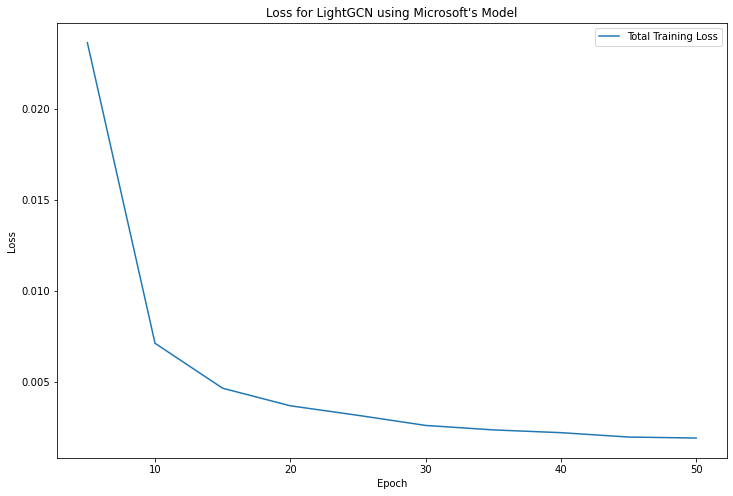

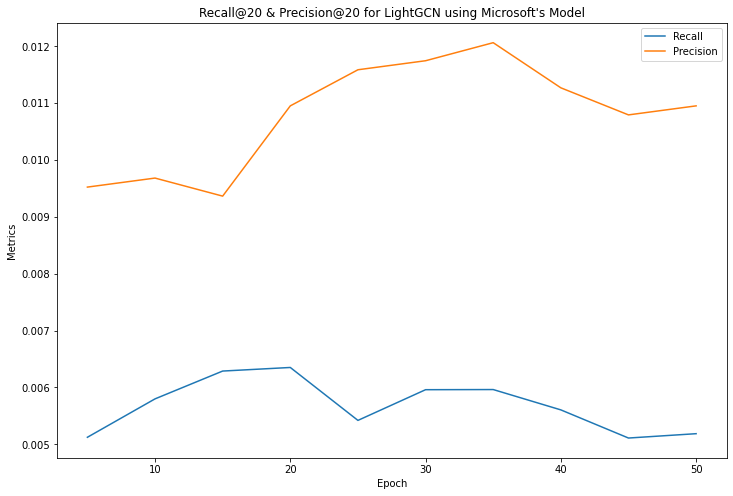

In [350]:
## PLOT RESULTS
epoch_list = list(range(args['eval_epoch'],args['epochs']+1,args['eval_epoch']))

fig = plt.figure(figsize=(12,8))
plt.plot(epoch_list, loss, label='Total Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Loss for LightGCN using Microsoft's Model")
plt.legend()
plt.show()

fig = plt.figure(figsize=(12,8))
plt.plot(epoch_list, recall, label='Recall')
plt.plot(epoch_list, precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title(f"Recall@{args['K']} & Precision@{args['K']} for LightGCN using Microsoft's Model")
plt.legend()
plt.show()

In [352]:
topk_scores = lightgcn_microsoft.recommend_k_items(test_df, top_k=args['K'], remove_seen=False)

eval_map = map_at_k(test_df, topk_scores, k=args['K'])
eval_precision = precision_at_k(test_df, topk_scores, k=args['K'])
eval_recall = recall_at_k(test_df, topk_scores, k=args['K'])

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.000035
Precision@K:	0.000159
Recall@K:	0.000635


In [354]:
predictTopK(lightgcn_microsoft, train_df, test_df, userID=4, K=args['K'], removeSeen=False)

,userID,itemID,prediction,inTrain,inTest
1340,4,3501,10.467842,True,False
1341,4,3464,9.882442,True,False
1342,4,3500,9.790209,True,False
1343,4,3485,9.519238,True,False
1344,4,3504,9.399839,True,False
1345,4,3502,8.370725,True,False
1346,4,3446,8.339659,True,False
1347,4,999,8.289755,True,False
1348,4,173,7.653675,True,False
1349,4,40,7.276745,True,False
